## This notebook includes:

#### 1) MLP with 2 hidden layers

#### 2) Inspecting the optimization algorithms SGD and Adam

#### 3) SGD with different learning rates $\{ 0.0001, 0.001, 0.01, 0.1, 1 \}$

#### 4) Adam with different learning rates $\{ 0.0001, 0.001, 0.01, 0.1, 1 \}$ 

#### 5) Inspecting the hidden layer dimension to $\{ 100, 1000, 2000\}$ 

## 1. Train feedforward networks with one hidden layer and one activation layer

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy

# Device configuration: check if there is a configured GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784        # 28 * 28
hidden_size = 500       # the output dimension of the linear model in each MLP hidden layer
num_classes = 10        # the number of classes
num_epochs = 10         # the number of epochs (each epoch: scanning the entire training set)
batch_size = 100        # how many samples are used in each iteration of SGD/Adam update
learning_rate = 0.001   # learning rate or step size used in gradient-based optimization algorithm

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


Epoch [1/10], Step [100/600], Loss: 0.3288
Epoch [1/10], Step [200/600], Loss: 0.2661
Epoch [1/10], Step [300/600], Loss: 0.2228
Epoch [1/10], Step [400/600], Loss: 0.1559
Epoch [1/10], Step [500/600], Loss: 0.2089
Epoch [1/10], Step [600/600], Loss: 0.1143
Accuracy of the network on the 10000 test images: 95.73 %
Accuracy of the network on the training images: 96.04833333333333 %
Epoch [2/10], Step [100/600], Loss: 0.1152
Epoch [2/10], Step [200/600], Loss: 0.1432
Epoch [2/10], Step [300/600], Loss: 0.1273
Epoch [2/10], Step [400/600], Loss: 0.1053
Epoch [2/10], Step [500/600], Loss: 0.0831
Epoch [2/10], Step [600/600], Loss: 0.0594
Accuracy of the network on the 10000 test images: 96.79 %
Accuracy of the network on the training images: 97.51833333333333 %
Epoch [3/10], Step [100/600], Loss: 0.0417
Epoch [3/10], Step [200/600], Loss: 0.0575
Epoch [3/10], Step [300/600], Loss: 0.0840
Epoch [3/10], Step [400/600], Loss: 0.0644
Epoch [3/10], Step [500/600], Loss: 0.1874
Epoch [3/10], Ste

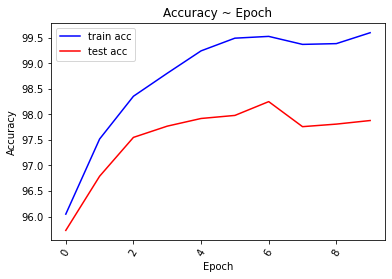

In [2]:
# Define a model using class NeuralNet()
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimization algorithm (optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

# Train the model
# train_acc_list, test_acc_list = [],[]
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model and plot training/testing accuracy
    # In test phase, we don't need to compute gradients 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
        test_acc_list.append(100 * correct / total)

        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
        train_acc_list.append(100 * correct / total)
            
plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
        
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

## 2. Implement and train a feedforward network with two hidden layers

In [3]:
class NeuralNet2(NeuralNet): 
    
  def __init__(self, input_size, hidden_size, num_classes):
      super(NeuralNet, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size) 
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(hidden_size, num_classes)  
      self.fc = nn.Linear(hidden_size, hidden_size) 

  def forward(self, x):
      out = self.fc1(x)
      out = self.relu(out)
      out = self.fc(out)
      out = self.relu(out)
      out = self.fc2(out)
      return out


Epoch [1/10], Step [100/600], Loss: 0.1433
Epoch [1/10], Step [200/600], Loss: 0.3241
Epoch [1/10], Step [300/600], Loss: 0.1608
Epoch [1/10], Step [400/600], Loss: 0.2365
Epoch [1/10], Step [500/600], Loss: 0.2865
Epoch [1/10], Step [600/600], Loss: 0.1489
Accuracy of the network on the 10000 test images: 96.13 %
Accuracy of the network on the training images: 96.84666666666666 %
Epoch [2/10], Step [100/600], Loss: 0.1047
Epoch [2/10], Step [200/600], Loss: 0.1186
Epoch [2/10], Step [300/600], Loss: 0.0916
Epoch [2/10], Step [400/600], Loss: 0.0520
Epoch [2/10], Step [500/600], Loss: 0.0458
Epoch [2/10], Step [600/600], Loss: 0.0879
Accuracy of the network on the 10000 test images: 97.18 %
Accuracy of the network on the training images: 98.08666666666667 %
Epoch [3/10], Step [100/600], Loss: 0.0495
Epoch [3/10], Step [200/600], Loss: 0.0876
Epoch [3/10], Step [300/600], Loss: 0.0301
Epoch [3/10], Step [400/600], Loss: 0.0712
Epoch [3/10], Step [500/600], Loss: 0.0160
Epoch [3/10], Ste

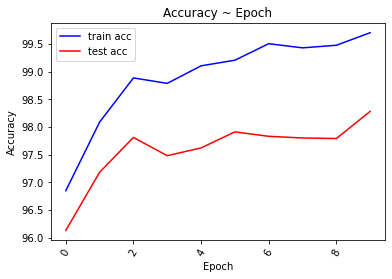

In [4]:

# Define a model using class NeuralNet()
model = NeuralNet2(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimization algorithm (optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

# Train the model
# train_acc_list, test_acc_list = [],[]
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model and plot training/testing accuracy
    # In test phase, we don't need to compute gradients 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
        test_acc_list.append(100 * correct / total)

        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
        train_acc_list.append(100 * correct / total)
            
plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
        
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


After training: plot training and testing accuracy (against #epoches) 

Hint: modify class NeuralNet

## 3. Use SGD to train the two-hidden-layer network.

Epoch [1/10], Step [100/600], Loss: 2.3062
Epoch [1/10], Step [200/600], Loss: 2.2892
Epoch [1/10], Step [300/600], Loss: 2.2920
Epoch [1/10], Step [400/600], Loss: 2.2920
Epoch [1/10], Step [500/600], Loss: 2.2777
Epoch [1/10], Step [600/600], Loss: 2.2735
Accuracy of the network on the 10000 test images: 24.61 %
Accuracy of the network on the training images: 24.128333333333334 %
Epoch [2/10], Step [100/600], Loss: 2.2770
Epoch [2/10], Step [200/600], Loss: 2.2597
Epoch [2/10], Step [300/600], Loss: 2.2558
Epoch [2/10], Step [400/600], Loss: 2.2601
Epoch [2/10], Step [500/600], Loss: 2.2462
Epoch [2/10], Step [600/600], Loss: 2.2435
Accuracy of the network on the 10000 test images: 43.87 %
Accuracy of the network on the training images: 42.46333333333333 %
Epoch [3/10], Step [100/600], Loss: 2.2333
Epoch [3/10], Step [200/600], Loss: 2.2235
Epoch [3/10], Step [300/600], Loss: 2.2258
Epoch [3/10], Step [400/600], Loss: 2.2224
Epoch [3/10], Step [500/600], Loss: 2.2087
Epoch [3/10], St

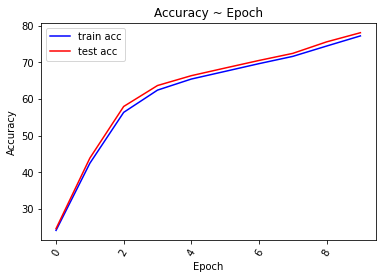

In [5]:
# Define a model using class NeuralNet()
model = NeuralNet2(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimization algorithm (optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

# Train the model
# train_acc_list, test_acc_list = [],[]
total_step = len(train_loader)
test_acc_list, train_acc_list = [], []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Test the model and plot training/testing accuracy
    # In test phase, we don't need to compute gradients 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
        test_acc_list.append(100 * correct / total)

        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
        train_acc_list.append(100 * correct / total)
            
plt.plot(train_acc_list, '-b', label='train acc')
plt.plot(test_acc_list, '-r', label='test acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Accuracy ~ Epoch')
# plt.savefig('assets/accr_{}.png'.format(cfg_idx))
plt.show()
        
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


## 4. Different learning rate values in the range of $\{ 0.0001, 0.001, 0.01, 0.1, 1 \}$ on SGD optimization.

Epoch [1/10], Step [100/600], Loss: 2.2983
Epoch [1/10], Step [200/600], Loss: 2.2862
Epoch [1/10], Step [300/600], Loss: 2.2981
Epoch [1/10], Step [400/600], Loss: 2.2970
Epoch [1/10], Step [500/600], Loss: 2.2998
Epoch [1/10], Step [600/600], Loss: 2.3013
Accuracy of the network on the 10000 test images: 14.26 %
Accuracy of the network on the training images: 13.93 %
Epoch [2/10], Step [100/600], Loss: 2.2973
Epoch [2/10], Step [200/600], Loss: 2.2930
Epoch [2/10], Step [300/600], Loss: 2.2955
Epoch [2/10], Step [400/600], Loss: 2.2999
Epoch [2/10], Step [500/600], Loss: 2.2926
Epoch [2/10], Step [600/600], Loss: 2.2870
Accuracy of the network on the 10000 test images: 15.91 %
Accuracy of the network on the training images: 15.355 %
Epoch [3/10], Step [100/600], Loss: 2.2853
Epoch [3/10], Step [200/600], Loss: 2.2927
Epoch [3/10], Step [300/600], Loss: 2.2925
Epoch [3/10], Step [400/600], Loss: 2.2961
Epoch [3/10], Step [500/600], Loss: 2.2927
Epoch [3/10], Step [600/600], Loss: 2.29

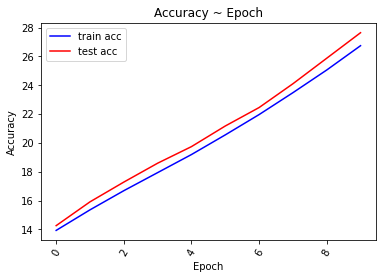

Epoch [1/10], Step [100/600], Loss: 2.2574
Epoch [1/10], Step [200/600], Loss: 2.2611
Epoch [1/10], Step [300/600], Loss: 2.2444
Epoch [1/10], Step [400/600], Loss: 2.2334
Epoch [1/10], Step [500/600], Loss: 2.2346
Epoch [1/10], Step [600/600], Loss: 2.2286
Accuracy of the network on the 10000 test images: 45.59 %
Accuracy of the network on the training images: 44.62 %
Epoch [2/10], Step [100/600], Loss: 2.2352
Epoch [2/10], Step [200/600], Loss: 2.2166
Epoch [2/10], Step [300/600], Loss: 2.2184
Epoch [2/10], Step [400/600], Loss: 2.2158
Epoch [2/10], Step [500/600], Loss: 2.1949
Epoch [2/10], Step [600/600], Loss: 2.1674
Accuracy of the network on the 10000 test images: 58.12 %
Accuracy of the network on the training images: 57.175 %
Epoch [3/10], Step [100/600], Loss: 2.1821
Epoch [3/10], Step [200/600], Loss: 2.1634
Epoch [3/10], Step [300/600], Loss: 2.1569
Epoch [3/10], Step [400/600], Loss: 2.1163
Epoch [3/10], Step [500/600], Loss: 2.1112
Epoch [3/10], Step [600/600], Loss: 2.14

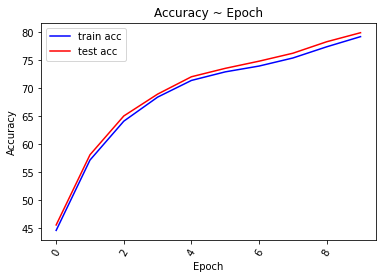

Epoch [1/10], Step [100/600], Loss: 0.7511
Epoch [1/10], Step [200/600], Loss: 0.6453
Epoch [1/10], Step [300/600], Loss: 0.6272
Epoch [1/10], Step [400/600], Loss: 0.5746
Epoch [1/10], Step [500/600], Loss: 0.5843
Epoch [1/10], Step [600/600], Loss: 0.3695
Accuracy of the network on the 10000 test images: 86.88 %
Accuracy of the network on the training images: 86.42666666666666 %
Epoch [2/10], Step [100/600], Loss: 0.4356
Epoch [2/10], Step [200/600], Loss: 0.5151
Epoch [2/10], Step [300/600], Loss: 0.5731
Epoch [2/10], Step [400/600], Loss: 0.4015
Epoch [2/10], Step [500/600], Loss: 0.3882
Epoch [2/10], Step [600/600], Loss: 0.5710
Accuracy of the network on the 10000 test images: 89.36 %
Accuracy of the network on the training images: 88.75 %
Epoch [3/10], Step [100/600], Loss: 0.4123
Epoch [3/10], Step [200/600], Loss: 0.5700
Epoch [3/10], Step [300/600], Loss: 0.3802
Epoch [3/10], Step [400/600], Loss: 0.3267
Epoch [3/10], Step [500/600], Loss: 0.3708
Epoch [3/10], Step [600/600],

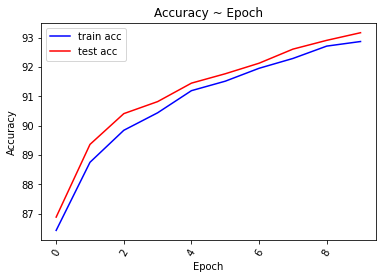

Epoch [1/10], Step [100/600], Loss: 0.1884
Epoch [1/10], Step [200/600], Loss: 0.2720
Epoch [1/10], Step [300/600], Loss: 0.1629
Epoch [1/10], Step [400/600], Loss: 0.1338
Epoch [1/10], Step [500/600], Loss: 0.2736
Epoch [1/10], Step [600/600], Loss: 0.1507
Accuracy of the network on the 10000 test images: 94.94 %
Accuracy of the network on the training images: 95.055 %
Epoch [2/10], Step [100/600], Loss: 0.1120
Epoch [2/10], Step [200/600], Loss: 0.1236
Epoch [2/10], Step [300/600], Loss: 0.1830
Epoch [2/10], Step [400/600], Loss: 0.1563
Epoch [2/10], Step [500/600], Loss: 0.2074
Epoch [2/10], Step [600/600], Loss: 0.0650
Accuracy of the network on the 10000 test images: 96.06 %
Accuracy of the network on the training images: 96.41166666666666 %
Epoch [3/10], Step [100/600], Loss: 0.1232
Epoch [3/10], Step [200/600], Loss: 0.0854
Epoch [3/10], Step [300/600], Loss: 0.0848
Epoch [3/10], Step [400/600], Loss: 0.1047
Epoch [3/10], Step [500/600], Loss: 0.0805
Epoch [3/10], Step [600/600]

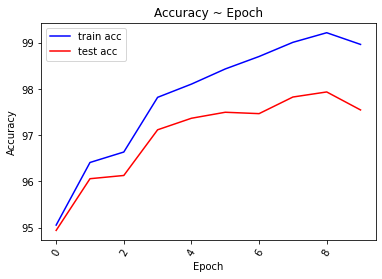

Epoch [1/10], Step [100/600], Loss: 1.9385
Epoch [1/10], Step [200/600], Loss: 1.8375
Epoch [1/10], Step [300/600], Loss: 1.7309
Epoch [1/10], Step [400/600], Loss: 1.6017
Epoch [1/10], Step [500/600], Loss: 1.7001
Epoch [1/10], Step [600/600], Loss: 1.2842
Accuracy of the network on the 10000 test images: 44.68 %
Accuracy of the network on the training images: 45.026666666666664 %
Epoch [2/10], Step [100/600], Loss: 1.5470
Epoch [2/10], Step [200/600], Loss: 1.5547
Epoch [2/10], Step [300/600], Loss: 1.3130
Epoch [2/10], Step [400/600], Loss: 1.0924
Epoch [2/10], Step [500/600], Loss: 1.5211
Epoch [2/10], Step [600/600], Loss: 1.0519
Accuracy of the network on the 10000 test images: 54.37 %
Accuracy of the network on the training images: 55.07333333333333 %
Epoch [3/10], Step [100/600], Loss: 1.1980
Epoch [3/10], Step [200/600], Loss: 0.9856
Epoch [3/10], Step [300/600], Loss: 1.1258
Epoch [3/10], Step [400/600], Loss: 1.1658
Epoch [3/10], Step [500/600], Loss: 0.9691
Epoch [3/10], St

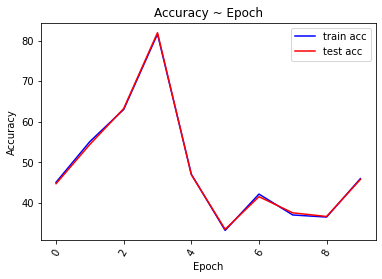

In [6]:
model = NeuralNet2(input_size, hidden_size, num_classes).to(device)

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for learning_rate in learning_rates: 
  # Define loss function and optimization algorithm (optimizer)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

  # Train the model
  # train_acc_list, test_acc_list = [],[]
  total_step = len(train_loader)
  test_acc_list, train_acc_list = [], []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

      # Test the model and plot training/testing accuracy
      # In test phase, we don't need to compute gradients 
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
          test_acc_list.append(100 * correct / total)

          
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in train_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
          train_acc_list.append(100 * correct / total)
              
  plt.plot(train_acc_list, '-b', label='train acc')
  plt.plot(test_acc_list, '-r', label='test acc')
  plt.legend()
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(rotation=60)
  plt.title('Accuracy ~ Epoch')
  # plt.savefig('assets/accr_{}.png'.format(cfg_idx))
  plt.show()



## 5. Different learning rate values in the range of $\{ 0.0001, 0.001, 0.01, 0.1, 1 \}$ woth Adam optimization

Epoch [1/10], Step [100/600], Loss: 0.8655
Epoch [1/10], Step [200/600], Loss: 0.4728
Epoch [1/10], Step [300/600], Loss: 0.4388
Epoch [1/10], Step [400/600], Loss: 0.3253
Epoch [1/10], Step [500/600], Loss: 0.3255
Epoch [1/10], Step [600/600], Loss: 0.4532
Accuracy of the network on the 10000 test images: 91.91 %
Accuracy of the network on the training images: 91.925 %
Epoch [2/10], Step [100/600], Loss: 0.1786
Epoch [2/10], Step [200/600], Loss: 0.3202
Epoch [2/10], Step [300/600], Loss: 0.3054
Epoch [2/10], Step [400/600], Loss: 0.1719
Epoch [2/10], Step [500/600], Loss: 0.2906
Epoch [2/10], Step [600/600], Loss: 0.3228
Accuracy of the network on the 10000 test images: 93.94 %
Accuracy of the network on the training images: 94.09 %
Epoch [3/10], Step [100/600], Loss: 0.1669
Epoch [3/10], Step [200/600], Loss: 0.2326
Epoch [3/10], Step [300/600], Loss: 0.1571
Epoch [3/10], Step [400/600], Loss: 0.1105
Epoch [3/10], Step [500/600], Loss: 0.1153
Epoch [3/10], Step [600/600], Loss: 0.09

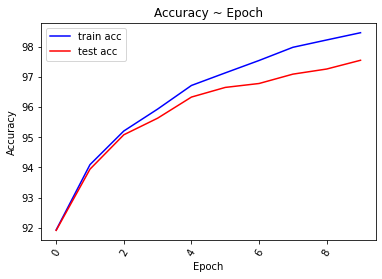

Epoch [1/10], Step [100/600], Loss: 0.0245
Epoch [1/10], Step [200/600], Loss: 0.0684
Epoch [1/10], Step [300/600], Loss: 0.1039
Epoch [1/10], Step [400/600], Loss: 0.1357
Epoch [1/10], Step [500/600], Loss: 0.0691
Epoch [1/10], Step [600/600], Loss: 0.0760
Accuracy of the network on the 10000 test images: 97.35 %
Accuracy of the network on the training images: 97.92833333333333 %
Epoch [2/10], Step [100/600], Loss: 0.0402
Epoch [2/10], Step [200/600], Loss: 0.0722
Epoch [2/10], Step [300/600], Loss: 0.0751
Epoch [2/10], Step [400/600], Loss: 0.0886
Epoch [2/10], Step [500/600], Loss: 0.0423
Epoch [2/10], Step [600/600], Loss: 0.1081
Accuracy of the network on the 10000 test images: 97.74 %
Accuracy of the network on the training images: 98.73833333333333 %
Epoch [3/10], Step [100/600], Loss: 0.0415
Epoch [3/10], Step [200/600], Loss: 0.0554
Epoch [3/10], Step [300/600], Loss: 0.0108
Epoch [3/10], Step [400/600], Loss: 0.0124
Epoch [3/10], Step [500/600], Loss: 0.0467
Epoch [3/10], Ste

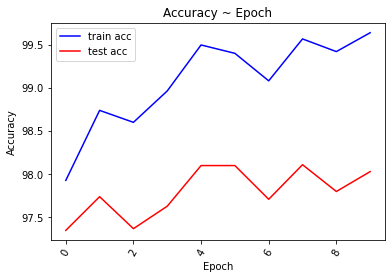

Epoch [1/10], Step [100/600], Loss: 0.0881
Epoch [1/10], Step [200/600], Loss: 0.0918
Epoch [1/10], Step [300/600], Loss: 0.1203
Epoch [1/10], Step [400/600], Loss: 0.0452
Epoch [1/10], Step [500/600], Loss: 0.1451
Epoch [1/10], Step [600/600], Loss: 0.1705
Accuracy of the network on the 10000 test images: 95.78 %
Accuracy of the network on the training images: 96.32 %
Epoch [2/10], Step [100/600], Loss: 0.1288
Epoch [2/10], Step [200/600], Loss: 0.1741
Epoch [2/10], Step [300/600], Loss: 0.2082
Epoch [2/10], Step [400/600], Loss: 0.2562
Epoch [2/10], Step [500/600], Loss: 0.1104
Epoch [2/10], Step [600/600], Loss: 0.1773
Accuracy of the network on the 10000 test images: 96.56 %
Accuracy of the network on the training images: 97.44833333333334 %
Epoch [3/10], Step [100/600], Loss: 0.0739
Epoch [3/10], Step [200/600], Loss: 0.0722
Epoch [3/10], Step [300/600], Loss: 0.0470
Epoch [3/10], Step [400/600], Loss: 0.0908
Epoch [3/10], Step [500/600], Loss: 0.2374
Epoch [3/10], Step [600/600],

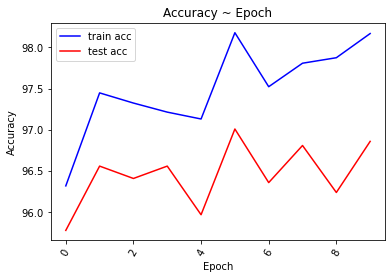

Epoch [1/10], Step [100/600], Loss: 0.5548
Epoch [1/10], Step [200/600], Loss: 0.3639
Epoch [1/10], Step [300/600], Loss: 0.7302
Epoch [1/10], Step [400/600], Loss: 0.8905
Epoch [1/10], Step [500/600], Loss: 0.3973
Epoch [1/10], Step [600/600], Loss: 0.4782
Accuracy of the network on the 10000 test images: 83.85 %
Accuracy of the network on the training images: 83.095 %
Epoch [2/10], Step [100/600], Loss: 0.4640
Epoch [2/10], Step [200/600], Loss: 0.9248
Epoch [2/10], Step [300/600], Loss: 1.4976
Epoch [2/10], Step [400/600], Loss: 2.1650
Epoch [2/10], Step [500/600], Loss: 2.3138
Epoch [2/10], Step [600/600], Loss: 2.3269
Accuracy of the network on the 10000 test images: 9.61 %
Accuracy of the network on the training images: 9.915 %
Epoch [3/10], Step [100/600], Loss: 2.3074
Epoch [3/10], Step [200/600], Loss: 2.3251
Epoch [3/10], Step [300/600], Loss: 2.3015
Epoch [3/10], Step [400/600], Loss: 2.2960
Epoch [3/10], Step [500/600], Loss: 2.3000
Epoch [3/10], Step [600/600], Loss: 2.320

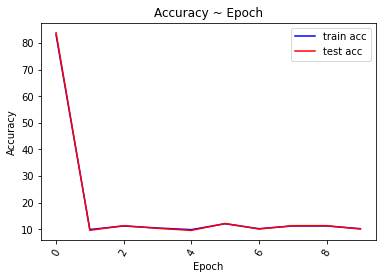

Epoch [1/10], Step [100/600], Loss: 2.2945
Epoch [1/10], Step [200/600], Loss: 2.1475
Epoch [1/10], Step [300/600], Loss: 2.1746
Epoch [1/10], Step [400/600], Loss: 2.1576
Epoch [1/10], Step [500/600], Loss: 2.2076
Epoch [1/10], Step [600/600], Loss: 2.0759
Accuracy of the network on the 10000 test images: 19.29 %
Accuracy of the network on the training images: 18.706666666666667 %
Epoch [2/10], Step [100/600], Loss: 2.1978
Epoch [2/10], Step [200/600], Loss: 2.2142
Epoch [2/10], Step [300/600], Loss: 2.1632
Epoch [2/10], Step [400/600], Loss: 2.1733
Epoch [2/10], Step [500/600], Loss: 2.0969
Epoch [2/10], Step [600/600], Loss: 2.0886
Accuracy of the network on the 10000 test images: 18.66 %
Accuracy of the network on the training images: 18.201666666666668 %
Epoch [3/10], Step [100/600], Loss: 2.0980
Epoch [3/10], Step [200/600], Loss: 2.1957
Epoch [3/10], Step [300/600], Loss: 2.2198
Epoch [3/10], Step [400/600], Loss: 2.9337
Epoch [3/10], Step [500/600], Loss: 2.1862
Epoch [3/10], S

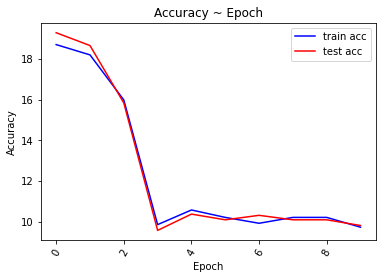

In [7]:
model = NeuralNet2(input_size, hidden_size, num_classes).to(device)

learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for learning_rate in learning_rates: 
  # Define loss function and optimization algorithm (optimizer)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

  # Train the model
  # train_acc_list, test_acc_list = [],[]
  total_step = len(train_loader)
  test_acc_list, train_acc_list = [], []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

      # Test the model and plot training/testing accuracy
      # In test phase, we don't need to compute gradients 
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
          test_acc_list.append(100 * correct / total)

          
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in train_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
          train_acc_list.append(100 * correct / total)
              
  plt.plot(train_acc_list, '-b', label='train acc')
  plt.plot(test_acc_list, '-r', label='test acc')
  plt.legend()
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(rotation=60)
  plt.title('Accuracy ~ Epoch')
  # plt.savefig('assets/accr_{}.png'.format(cfg_idx))
  plt.show()




## 6. Dimensions of the hidden variable from $500$ to $100, 1000, 2000$

Epoch [1/10], Step [100/600], Loss: 0.4666
Epoch [1/10], Step [200/600], Loss: 0.2123
Epoch [1/10], Step [300/600], Loss: 0.2895
Epoch [1/10], Step [400/600], Loss: 0.1883
Epoch [1/10], Step [500/600], Loss: 0.1540
Epoch [1/10], Step [600/600], Loss: 0.3345
Accuracy of the network on the 10000 test images: 94.29 %
Accuracy of the network on the training images: 94.56333333333333 %
Epoch [2/10], Step [100/600], Loss: 0.0747
Epoch [2/10], Step [200/600], Loss: 0.1293
Epoch [2/10], Step [300/600], Loss: 0.1397
Epoch [2/10], Step [400/600], Loss: 0.1637
Epoch [2/10], Step [500/600], Loss: 0.1176
Epoch [2/10], Step [600/600], Loss: 0.2827
Accuracy of the network on the 10000 test images: 96.12 %
Accuracy of the network on the training images: 96.565 %
Epoch [3/10], Step [100/600], Loss: 0.1264
Epoch [3/10], Step [200/600], Loss: 0.0823
Epoch [3/10], Step [300/600], Loss: 0.0705
Epoch [3/10], Step [400/600], Loss: 0.1560
Epoch [3/10], Step [500/600], Loss: 0.0783
Epoch [3/10], Step [600/600]

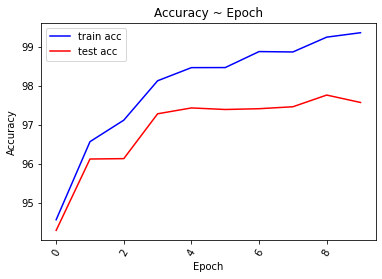

Epoch [1/10], Step [100/600], Loss: 0.2156
Epoch [1/10], Step [200/600], Loss: 0.1491
Epoch [1/10], Step [300/600], Loss: 0.2689
Epoch [1/10], Step [400/600], Loss: 0.0774
Epoch [1/10], Step [500/600], Loss: 0.0617
Epoch [1/10], Step [600/600], Loss: 0.1119
Accuracy of the network on the 10000 test images: 96.91 %
Accuracy of the network on the training images: 97.50833333333334 %
Epoch [2/10], Step [100/600], Loss: 0.0968
Epoch [2/10], Step [200/600], Loss: 0.0887
Epoch [2/10], Step [300/600], Loss: 0.0632
Epoch [2/10], Step [400/600], Loss: 0.1039
Epoch [2/10], Step [500/600], Loss: 0.0977
Epoch [2/10], Step [600/600], Loss: 0.0209
Accuracy of the network on the 10000 test images: 96.87 %
Accuracy of the network on the training images: 98.04333333333334 %
Epoch [3/10], Step [100/600], Loss: 0.1004
Epoch [3/10], Step [200/600], Loss: 0.0147
Epoch [3/10], Step [300/600], Loss: 0.1194
Epoch [3/10], Step [400/600], Loss: 0.0089
Epoch [3/10], Step [500/600], Loss: 0.1153
Epoch [3/10], Ste

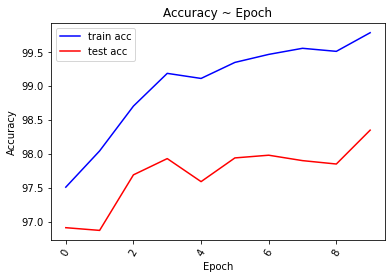

Epoch [1/10], Step [100/600], Loss: 0.2668
Epoch [1/10], Step [200/600], Loss: 0.1016
Epoch [1/10], Step [300/600], Loss: 0.2035
Epoch [1/10], Step [400/600], Loss: 0.2431
Epoch [1/10], Step [500/600], Loss: 0.1049
Epoch [1/10], Step [600/600], Loss: 0.1113
Accuracy of the network on the 10000 test images: 96.78 %
Accuracy of the network on the training images: 97.31833333333333 %
Epoch [2/10], Step [100/600], Loss: 0.0588
Epoch [2/10], Step [200/600], Loss: 0.0327
Epoch [2/10], Step [300/600], Loss: 0.0333
Epoch [2/10], Step [400/600], Loss: 0.0714
Epoch [2/10], Step [500/600], Loss: 0.0473
Epoch [2/10], Step [600/600], Loss: 0.1074
Accuracy of the network on the 10000 test images: 97.32 %
Accuracy of the network on the training images: 98.16666666666667 %
Epoch [3/10], Step [100/600], Loss: 0.1023
Epoch [3/10], Step [200/600], Loss: 0.0533
Epoch [3/10], Step [300/600], Loss: 0.0234
Epoch [3/10], Step [400/600], Loss: 0.0309
Epoch [3/10], Step [500/600], Loss: 0.0450
Epoch [3/10], Ste

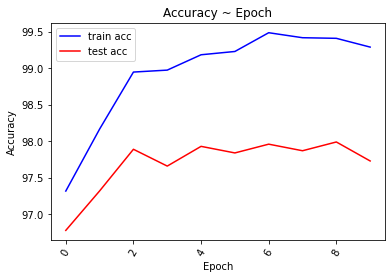

In [8]:

hidden_sizes = [100, 1000, 2000]
learning_rate = 1e-3
for hidden_size in hidden_sizes:
  # model 
  model = NeuralNet2(input_size, hidden_size, num_classes).to(device)

  # Define loss function and optimization algorithm (optimizer)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)  

  # Train the model
  # train_acc_list, test_acc_list = [],[]
  total_step = len(train_loader)
  test_acc_list, train_acc_list = [], []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.reshape(-1, 28*28).to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

      # Test the model and plot training/testing accuracy
      # In test phase, we don't need to compute gradients 
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in test_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
          test_acc_list.append(100 * correct / total)

          
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in train_loader:
              images = images.reshape(-1, 28*28).to(device)
              labels = labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          print('Accuracy of the network on the training images: {} %'.format(100 * correct / total))
          train_acc_list.append(100 * correct / total)
              
  plt.plot(train_acc_list, '-b', label='train acc')
  plt.plot(test_acc_list, '-r', label='test acc')
  plt.legend()
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(rotation=60)
  plt.title('Accuracy ~ Epoch')
  # plt.savefig('assets/accr_{}.png'.format(cfg_idx))
  plt.show()


    